<a href="https://colab.research.google.com/github/Jonathan-C-Barrett/GEOG5990M/blob/main/GEOG5003M_Final_Project_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEOG5003M Final Assignment (Template)

Student ID number:

GitHub repo link:

Word count limit= 1,500 words max (markdown cells only, excluding readme)

# Read in Packages

In [ ]:
#Install required packages
!pip install mapclassify
!pip install contextily
!pip install geoplot
!pip install git+https://github.com/pmdscully/geo_northarrow.git


# read in required packages
import geopandas as gpd
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs
from geo_northarrow import add_north_arrow



# import the required machine learning packages
from sklearn import cluster
from sklearn.preprocessing import scale





# Data and Preprocessing

**HEALTH SERVICE ACCESS DATA**

In [ ]:
#Read in Health Services Data
ahah = pd.read_csv('https://github.com/Jonathan-C-Barrett/GEOG5990M/raw/refs/heads/main/ahah_v4.csv')
ahah.head()

In [ ]:
#Select only columns relating to Health Services
health = ahah[['LSOA21CD', 'ah4dent', 'ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h']]
health.head()

In [ ]:
#check for missing values
health.isna().sum()

**MEDIAN PROPERTY VALUE DATA**

In [ ]:
#Read in Median Property Price
m_value = pd.read_csv('https://github.com/Jonathan-C-Barrett/GEOG5990M/raw/refs/heads/main/land-registry-house-prices-Meidan-LSOA.csv')
m_value.head()

In [ ]:
#Select only columns relating to 2016
prop_16 = m_value[['Code', 'Area','Year ending Mar 2016','Year ending Jun 2016', 'Year ending Sep 2016', 'Year ending Dec 2016']]
prop_16.head()

In [ ]:
#examine property info for count and data type
prop_16.info()

In [ ]:
#check for missing values
prop_16.isna().sum()

In [ ]:
#create a column of mean year value to counter missing values
prop_16['2016_mean'] = prop_16[['Year ending Mar 2016', 'Year ending Jun 2016', 'Year ending Sep 2016', 'Year ending Dec 2016']].mean(axis=1)
prop_16.head()

In [ ]:
prop_16.isna().sum()

**LSOA 2011 TO LSOA 2021 COVERSION DATA**

In [ ]:
#add conversion to LSOA21
LSOA21 = pd.read_csv('https://github.com/Jonathan-C-Barrett/GEOG5990M/raw/refs/heads/main/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Best_Fit_Lookup_for_EW_(V2).csv')
LSOA21.head()


In [ ]:
#inspect info for data type
LSOA21.info()

In [ ]:
#combine prop_16 data and LSOA21 by code in prop_16 and LSOA11CD in LSOA21 in to remove areas outside london and make comparable
prop_16_LSOA21 = pd.merge(prop_16, LSOA21, left_on='Code', right_on='LSOA11CD', how='left')
prop_16_LSOA21.head()

In [ ]:
#check Info for count
prop_16_LSOA21.info()

**COMBINE HEALTH ACCESS AND PROPERTY VALUE DATABASES**

In [ ]:
#combine health and property data by LSOA code in property to remove areas outside london
health_prop = pd.merge(health, prop_16_LSOA21, left_on='LSOA21CD', right_on='LSOA21CD', how='right')
health_prop.head()

In [ ]:
#check info for data frame to check count and data type
health_prop.info()

In [ ]:
#check for missing values
health_prop.isnull().sum()

In [19]:
#remove missing values from Year mean column
health_prop = health_prop.dropna(subset=['2016_mean'])

In [ ]:
#Check removed 2016 Mean missing values
health_prop.isnull().sum()

In [ ]:
#remove duplicated and unneccessary columns from Data base
health_prop_clean = health_prop.drop(columns=['Code', 'Area', 'LSOA11NM', 'LSOA11CD', 'ObjectId','LAD22NMW', 'Year ending Mar 2016', 'Year ending Jun 2016','Year ending Sep 2016','Year ending Dec 2016', ])
health_prop_clean.head()


In [ ]:
#check data type and missing values of required columns
health_prop_clean.info()


**INVESTIGATE DISTRIBUTION OF DATA AND REMOVAL OF OUTLIERS**

In [ ]:
#check basic geometry of data
health_prop_clean.describe()

In [ ]:
#Explore correlation between property price mean and health service float data with pairplot
sns.pairplot(health_prop_clean[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']]);

In [ ]:
#check for outliers observed in pairplot
health_prop_clean['2016_mean'].nlargest(n=25)

In [ ]:
#use boxplot to inspect impact of outliers
sns.boxplot(data=health_prop_clean, x='2016_mean');
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)


In [ ]:
sns.boxplot(data=health_prop_clean, x='ah4gp');

In [ ]:
sns.boxplot(data=health_prop_clean, x='ah4hosp');

In [ ]:
sns.boxplot(data=health_prop_clean, x='ah4leis');

In [ ]:
sns.boxplot(data=health_prop_clean, x='ah4h');

In [25]:
#remove outliers in 2016 mean using interquartle range method
#find intterquartile range
Q1 = health_prop_clean['2016_mean'].quantile(0.25)
Q3 = health_prop_clean['2016_mean'].quantile(0.75)
IQR = Q3 - Q1

In [26]:
#view Q1, Q3 and IQR
Q1, Q3, IQR

(np.float64(338492.5), np.float64(574418.75), np.float64(235926.25))

In [27]:
#find upper and lower limits
upper_limit = Q3 + (1.5 * IQR)
lower_limit = Q1 - (1.5 * IQR)
lower_limit, upper_limit

(np.float64(-15396.875), np.float64(928308.125))

In [ ]:
#find outliers
outliers = health_prop_clean[(health_prop_clean['2016_mean'] > upper_limit) | (health_prop_clean['2016_mean'] < lower_limit)]
outliers

In [29]:
#trim the data
health_prop_clean_trim = health_prop_clean[(health_prop_clean['2016_mean'] < upper_limit) & (health_prop_clean['2016_mean'] > lower_limit)]


In [30]:
#check for difference in data
print('before removing outliers', health_prop_clean.shape)
print('after removing outliers', health_prop_clean_trim.shape)

before removing outliers (4778, 11)
after removing outliers (4461, 11)


# Data Exploration

**CORRELATION THROUGH SPEARMANS RANK**

In [ ]:
#Calculate Spearmans Rank Correlation for all float data

health_prop_corr =health_prop_clean_trim[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']].corr(method = 'spearman')
health_prop_corr


In [ ]:
#Visualize spearmans correlation

# define plot size
fig,ax = plt.subplots(figsize=(8,8))

# define mask to apply to upper right hand corner of the plot
data_to_mask = np.triu(np.ones_like(health_prop_corr))

# define axis labels
x_axis_labels = health_prop_corr.columns
y_axis_labels = health_prop_corr.index


#capatlise each label is x and Y
x_axis_labels = [element.capitalize() for element in x_axis_labels]
y_axis_labels = [element.capitalize() for element in y_axis_labels]

# plot a heatmap of the correlation
sns.heatmap(health_prop_corr,
            #exband linewith for clarity
            linewidths=.5,
            # include spearmans value in squares
            annot=True,
            # define colourmap
            cmap='RdBu',
            # define value of minimum colour on cbar
            vmin=-1,
            # define value of maximum colour on cbar
            vmax=1,
            # add the mask
            mask=data_to_mask,
            # use the custom labels
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels,
            # add a label to the cbar
            cbar_kws={'label': "Spearman's Rank correlation"},
            # plot on the axis we defined
            ax=ax)

# Set axis labels
ax.set(xlabel="Property Value and Access to Health Services",
       ylabel="Property Value and Access to Health Services",
      title ='Property Value and Access to Health Services Correlation' );


**Create Inner and Outer boruough classification**

In [33]:
#create column of inner or outer borough for additional information in visualisation
inner_london_boroughs = ('Camden', 'City of London', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 'Wandsworth', 'Westminster')

for index, row in health_prop_clean_trim.iterrows():
  if row['LAD22NM'] in inner_london_boroughs:
    health_prop_clean_trim.loc[index, 'inner_outer'] = 'Inner Borough'
  else:
    health_prop_clean_trim.loc[index, 'inner_outer'] = 'Outer Borough'

/tmp/ipython-input-33-3333621687.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_prop_clean_trim.loc[index, 'inner_outer'] = 'Inner Borough'


In [34]:
#check inner_outer has worked correctly
num_unique_categories = health_prop_clean_trim['inner_outer'].nunique()
print(f"Number of unique categories: {num_unique_categories}")

Number of unique categories: 2


# Non Spatial Visulation

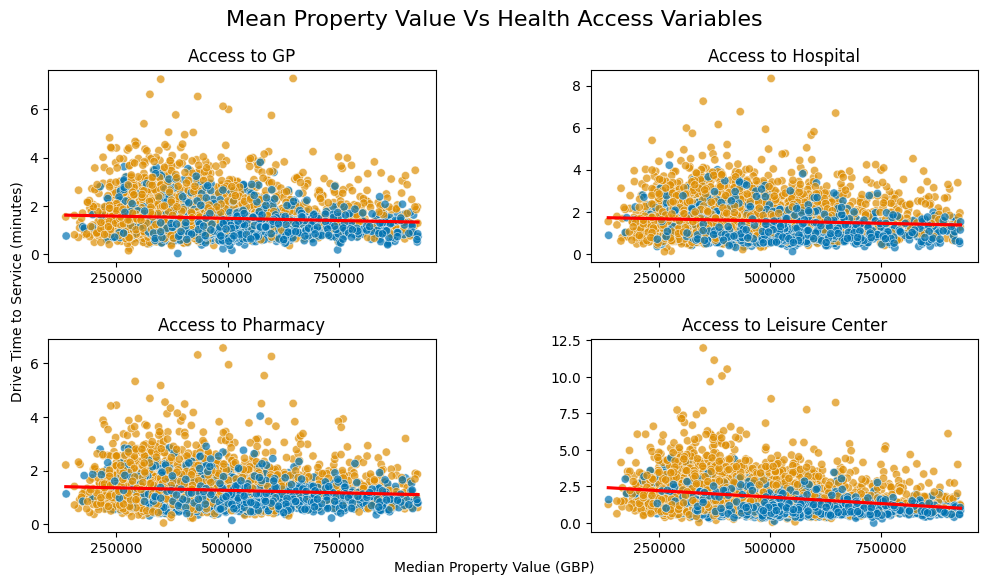

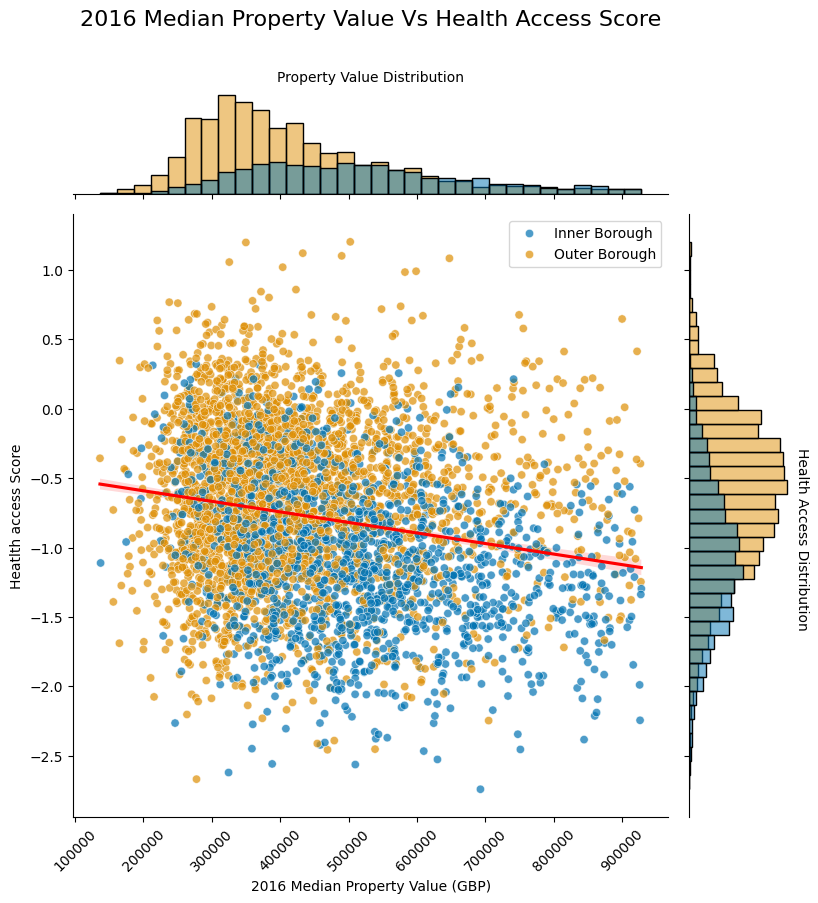

In [190]:
#create four subplots of health service individual variables
f,ax = plt.subplots(2,2, figsize=(12,6))
#widen space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

#Add title to subplots
f.suptitle('Mean Property Value Vs Health Access Variables ', fontsize=16)


#plot distance to gp in plot 1
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4gp', hue='inner_outer', legend=False, marker= "o", palette='colorblind', alpha =0.7, ax=ax[0,0], ).locator_params(axis='x', nbins=3)
#Add Title to plot
ax[0, 0].set_title('Access to GP')
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4gp", scatter=False, ax=ax[0,0], color='red')
#remove xaxis title
ax[0,0].set_xlabel('')
#remove yaxis title
ax[0,0].set_ylabel('')



#plot distance to hospital in plot 2
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4hosp', hue='inner_outer', legend=False, marker= "o", palette='colorblind', alpha =0.7, ax=ax[0,1]).locator_params(axis='x', nbins=3)
#Add title to plot
ax[0, 1].set_title('Access to Hospital')
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4hosp", scatter=False, ax=ax[0,1], color='red')
#remove xaxis title
ax[0,1].set_xlabel('')
#remove yaxis title
ax[0,1].set_ylabel('')



#plot distance to pharmacy in plot 3
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4phar', hue='inner_outer', legend=False,  marker= "o", palette='colorblind', alpha =0.7, ax=ax[1,0]).locator_params(axis='x', nbins=3)
#add plot title
ax[1,0 ].set_title('Access to Pharmacy')
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4phar", scatter=False, ax=ax[1,0], color='red')
#remove xaxis title
ax[1,0].set_xlabel('')
#center y label to use for four plots
ax[1,0].set_ylabel('Drive Time to Service (minutes)', y=1.25,fontsize=10)

#plot distance to leisure center in plot 4
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4leis', hue='inner_outer', legend=False,  marker= "o", palette='colorblind', alpha =0.7, ax=ax[1,1]).locator_params(axis='x', nbins=3)
#add plot title
ax[1, 1].set_title('Access to Leisure Center')
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4leis", scatter=False, ax=ax[1,1], color='red')
#center x label to use for four plots
ax[1,1].set_xlabel('Median Property Value (GBP)', x=-0.25,fontsize=10)
#remove yaxis title
ax[1,1].set_ylabel('')

#LARGE PLOT


#plot overal health access score vs property value
g=sns.JointGrid(data=health_prop_clean_trim, x='2016_mean', y='ah4h', hue="inner_outer", height =8)

#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4h", scatter=False, ax=g.ax_joint, color='red')

#remove scientific formating to include full house price
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)

#plot health access score vs property value as scatter plot
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4h', hue='inner_outer', palette='colorblind', alpha =0.7, ax=g.ax_joint)

#plothistograms on x-axis showing distribution of house price
sns.histplot(data=health_prop_clean_trim, x='2016_mean', hue="inner_outer", palette='colorblind', ax=g.ax_marg_x)

#plot histogram on y-axis showing distribution of health access score
sns.histplot(data=health_prop_clean_trim, y='ah4h', hue="inner_outer", palette='colorblind', ax=g.ax_marg_y)

#Remove legend from axis histograms
g.ax_marg_y.legend_.remove()
g.ax_marg_x.legend_.remove()

#Remove title from main legend
g.ax_joint.get_legend().set_title("")

#add title to property value distribution and set size
g.ax_marg_x.set_title('Property Value Distribution', fontsize=10)

#add title to Health Access Score distribution, set size, rotate and align to axis using x and y
g.ax_marg_y.set_title('Health Access Distribution', fontsize=10, rotation=270, y=0.3, x=1.1)

#Edit Axis Labels and set size
g.ax_joint.set_ylabel('Heatlth access Score', fontsize=10)
g.ax_joint.set_xlabel('2016 Median Property Value (GBP)', fontsize=10);

#change orientation of x-axis ticks
g.ax_joint.tick_params(axis='x', rotation=45)

#add title to map and set position and fontsize
g.ax_joint.set_title('2016 Median Property Value Vs Health Access Score', fontsize=16, y=1.3);

# LOCAL AUTHORITY DISTRICT (LAD) VISUALISTAION

**COMBINING LAD BOUNDARY GEOMETRY AND HEALTH ACCESS Vs PROPERTY VALUE**

In [36]:
# Data downloaded from https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-may-2024-boundaries-uk-bfe-2/explore?location=51.468470%2C-0.040938%2C9.90
shp = gpd.read_file('https://github.com/Jonathan-C-Barrett/GEOG5990M/raw/main/Local_Authority_Districts_May_2024_Boundaries_UK_BFE_2410925873296837173.geojson')



In [ ]:
#inspect data
shp.head()

In [ ]:
#group property and health data by Local Authority District
health_prop_LAD = health_prop_clean_trim.groupby('LAD22NM').mean(numeric_only=True)
health_prop_LAD.head(n=35)

In [ ]:
#convert 2016 property mean to more easily comparable by dividing by /100,000
health_prop_LAD['2016_mean'] = health_prop_LAD['2016_mean']/100000
health_prop_LAD.head()


In [ ]:
#explore basic statistics
health_prop_LAD.describe()

In [ ]:
#Cobine property and Health access data with geoson LAD boundaries and check all 33 Boroughs present
health_prop_LAD_ldn = pd.merge(shp, health_prop_LAD, left_on='LAD24NM', right_on='LAD22NM', how='right')
health_prop_LAD_ldn.head(n=35)

In [ ]:
#check data on leaflet map
health_prop_LAD_ldn.explore()

**EXPLORE CORRELATION AT LAD SCALE**

In [ ]:
#Examine correlation between data at LAD level using Spearmans rank
health_prop_LADcorr = health_prop_LAD_ldn[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']].corr(method = 'spearman')
health_prop_LADcorr

In [ ]:
#visualise correlation
# define plot size
fig,ax = plt.subplots(figsize=(8,8))

# define mask to apply to upper right hand corner of the plot
data_to_mask = np.triu(np.ones_like(health_prop_LADcorr))

# define axis labels
x_axis_labels = health_prop_LADcorr.columns
y_axis_labels = health_prop_LADcorr.index


#capatlise each label is x and Y
x_axis_labels = [element.capitalize() for element in x_axis_labels]
y_axis_labels = [element.capitalize() for element in y_axis_labels]

# plot a heatmap of the correlation
sns.heatmap(health_prop_LADcorr,
            #exband linewith for clarity
            linewidths=.5,
            # include spearmans value in sqaures
            annot=True,
            # define colourmap
            cmap='RdBu',
            # define value of minimum colour on cbar
            vmin=-1,
            # define value of maximum colour on cbar
            vmax=1,
            # add the mask
            mask=data_to_mask,
            # use the custom labels
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels,
            # add a label to the cbar
            cbar_kws={'label': "Spearman's Rank correlation"},
            # plot on the axis we defined
            ax=ax)

# Set axis labels
ax.set(xlabel="Property Value and Access to Health Services",
       ylabel="Property Value and Access to Health Services",
      title ='Property Value and Access to Health Services Correlation' );


In [ ]:
#Decide on number of clusters through elbow method
# create an empty list
Sum_of_squared_distances = []

# get a range of numbers from 1 to 15
K = range(1,15)
#for each number in the range 1 to 15create a k-means model with that number of clusters and set a random state
for k in K:
    km = cluster.KMeans(n_clusters=k, init="random", random_state=123)
    # fit the model using the variables from database
    km = km.fit(health_prop_LAD_ldn[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis','2016_mean']].values)
    # calculate the sum of the squared distances and add this to the 'Sum_of_squared_distances' list
    Sum_of_squared_distances.append(km.inertia_)

# plot the sum of squared distances against the number of clusters
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [69]:
# run the model with minimum needed for minimal change in this instance 4
km4 = cluster.KMeans(n_clusters=4,init="random", random_state=123)
km4cls = km4.fit(health_prop_LAD_ldn[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis','2016_mean']].values)

In [70]:
#create a new column in db with cluster label
health_prop_LAD_ldn['cluster'] = km4cls.labels_
health_prop_LAD_ldn['cluster'].head()

,cluster
0,3
1,2
2,0
3,2
4,0


In [ ]:
# Create a pairplot which shows relationship between variables captured by clustering
sns.pairplot(health_prop_LAD_ldn[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis','2016_mean','cluster']],
             hue='cluster',
             palette='Dark2',
            height=5);

In [ ]:
#Plot the spatial pattern of these clusters
f, ax = plt.subplots(1, figsize=(9, 9))

health_prop_LAD_ldn.plot(column='cluster', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

In [73]:
#groupby cluster to get the median value of each variable by cluster
health_prop_LAD_clusters_median=health_prop_LAD_ldn.groupby('cluster')[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis','2016_mean']].median().reset_index()

In [ ]:
#explore median values
health_prop_LAD_clusters_median

In [75]:
# transform data to a long format to plot
health_prop_LAD_clusters_median_to_plot =pd.melt(health_prop_LAD_clusters_median,id_vars='cluster',
                                            value_vars=['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis','2016_mean'])

In [ ]:
# check what the data now look like
health_prop_LAD_clusters_median_to_plot.head()

In [ ]:
# Plot a faceted bar chart, where each row is a different cluster

sns.catplot(health_prop_LAD_clusters_median_to_plot,
            row='cluster',
            y='variable',
            x='value',
            kind='bar',
            aspect=4,
            hue='value',
            palette='summer')



In [78]:
#changecluster naming
#create empty column
health_prop_LAD_ldn['Cluster_description']=""

In [80]:
#update names of each cluster
health_prop_LAD_ldn.loc[health_prop_LAD_ldn['cluster']==0,'Cluster_description']='Medium Value Low Access'
health_prop_LAD_ldn.loc[health_prop_LAD_ldn['cluster']==1,'Cluster_description']='High Value Good Access'
health_prop_LAD_ldn.loc[health_prop_LAD_ldn['cluster']==2,'Cluster_description']='Medium High Value Medium Access'
health_prop_LAD_ldn.loc[health_prop_LAD_ldn['cluster']==3,'Cluster_description']='Low Value Medium Access'

# Spatial Visualisation

In [84]:
#Check CRS of datafame
health_prop_LAD_ldn.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [85]:
#convert crs to  Web Mercator projection (epsg=3857) to work with base maps
health_prop_LAD_ldn_WM = health_prop_LAD_ldn.to_crs(epsg=3857)

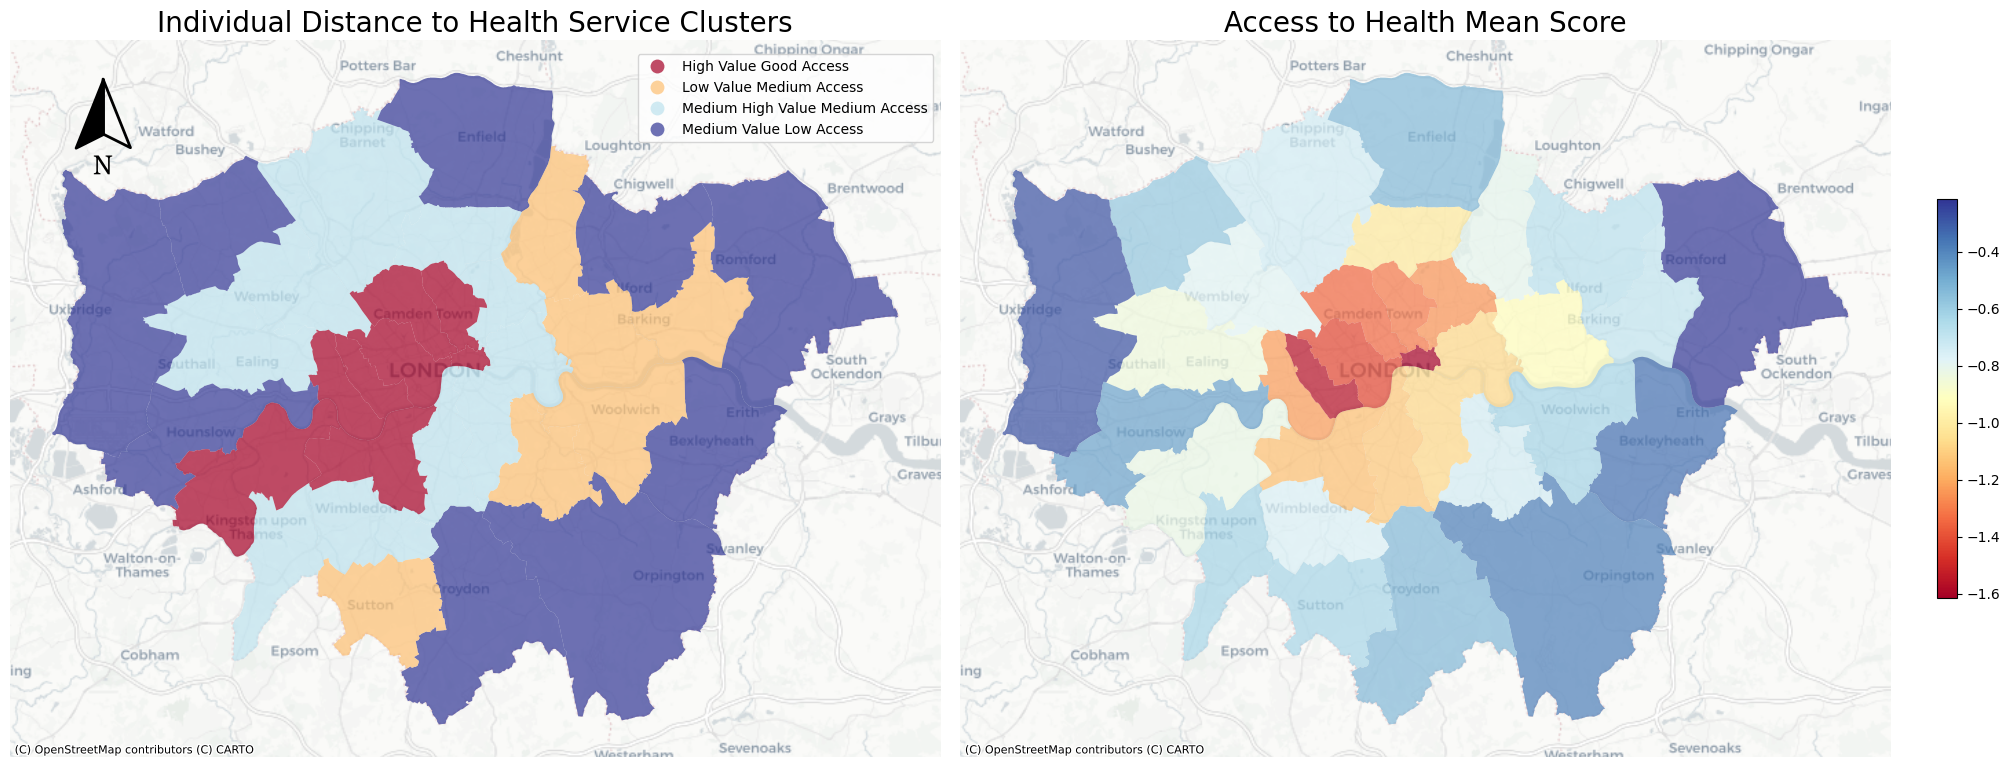

In [165]:
# Data Visualisation

#create a figure with 3 subplots
f,ax = plt.subplots(1,2, figsize=(20,20), layout='constrained')


#plot cluster description
health_prop_LAD_ldn_WM.plot(ax=ax[0], column ='Cluster_description', alpha=0.7, cmap='RdYlBu', legend=True)
#add basemap
ctx.add_basemap(ax=ax[0], source=ctx.providers.CartoDB.Positron, crs=health_prop_LAD_ldn_WM.crs)
# add title
ax[0].set_title('Individual Distance to Health Service Clusters', fontsize=20)
# add a North arrow
add_north_arrow(ax=ax[0], scale=.75, xlim_pos=0.1, ylim_pos=.85, color='#000', text_scaler=2, text_yT=-1.25)
# position legend
ax[0].get_legend().set_bbox_to_anchor((1.0, 0.99))


#plot health access score
health_prop_LAD_ldn_WM.plot(ax=ax[1], column ='ah4h', alpha=0.7, legend=True, cmap='RdYlBu',legend_kwds={'shrink': 0.2})
#add basemap
ctx.add_basemap(ax=ax[1], source=ctx.providers.CartoDB.Positron, crs=health_prop_LAD_ldn_WM.crs)
# add title
ax[1].set_title('Access to Health Mean Score', fontsize=20)

# make axis invisible for subplot 1
ax[0].set_axis_off()

# make axis invisible for subplot 2
ax[1].set_axis_off()

plt.show();

This is an example block of mardown text I want to reference <a href="#ref1">[1]</a>. I might need to add some more citations <a href="#ref2">[2]</a><a href="#ref2">[3]</a>



Data Visualisation
- Don't forget to present your final two data visualisation (one spatial and one non-spatial) and the justifications about the decisions you made whilst preparing and visualising the data.

## References
<p><a href="add_url_here">[1]</a>Footnote citation goes here</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5990">[2]</a>GEOG5990M course materials</p>
<p><a href="add_url_here">[3]</a>Citation 3</p>